We will build a model to try to predict whether a certain image contains a picture of a cactus. We will begin with the necessary imports and checking how many of the photos contain cactuses. Next, we will get a sense of the dataet by displaying ten of the photos along with whether or not they contain cactuses. We will also prepare the data for processing.



/kaggle/input/aerial-cactus-identification/sample_submission.csv
/kaggle/input/aerial-cactus-identification/train.zip
/kaggle/input/aerial-cactus-identification/test.zip
/kaggle/input/aerial-cactus-identification/train.csv
has_cactus
1    13136
0     4364
Name: count, dtype: int64


,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


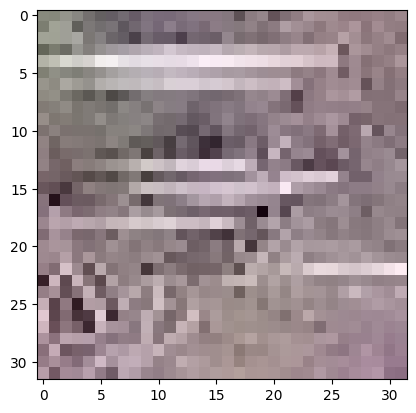

1


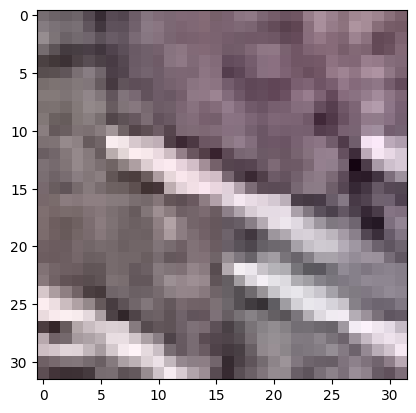

1


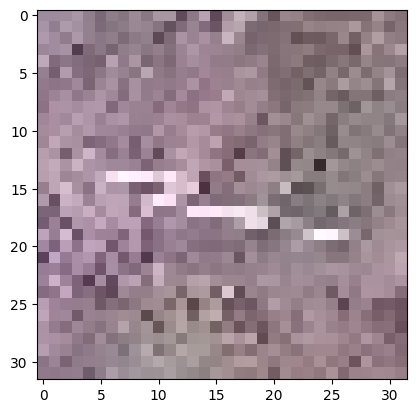

1


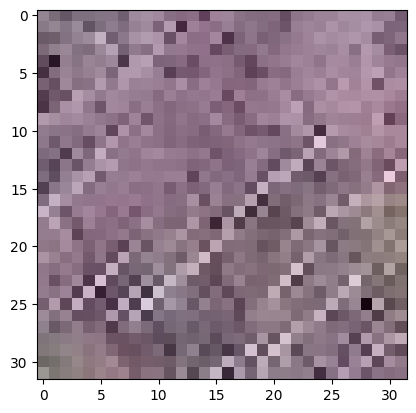

1


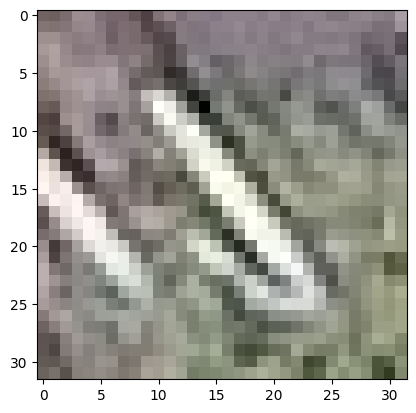

1


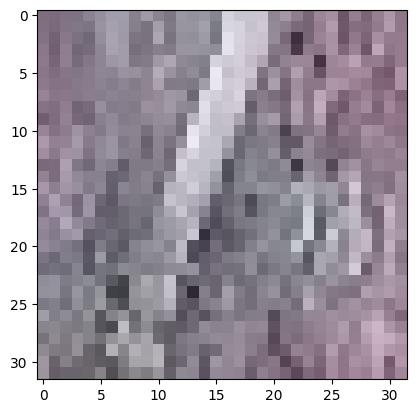

1


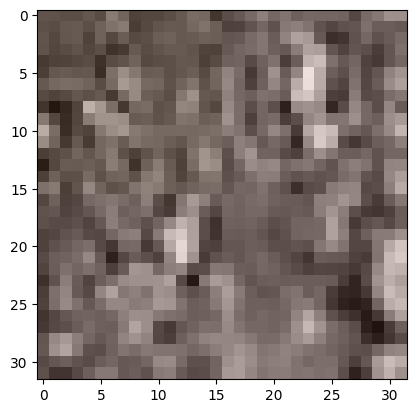

0


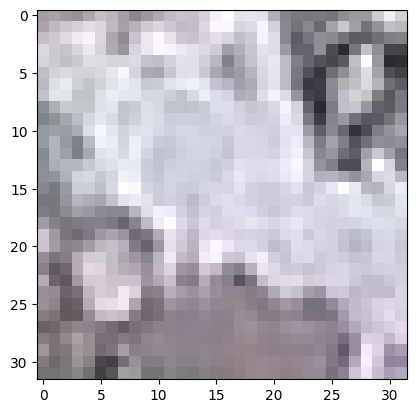

0


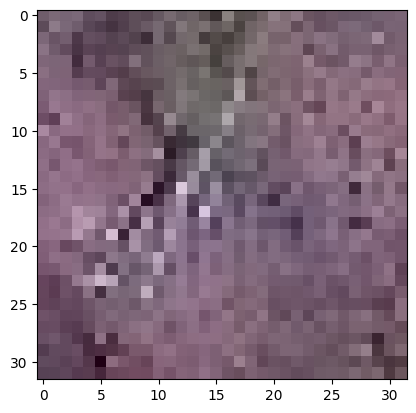

1


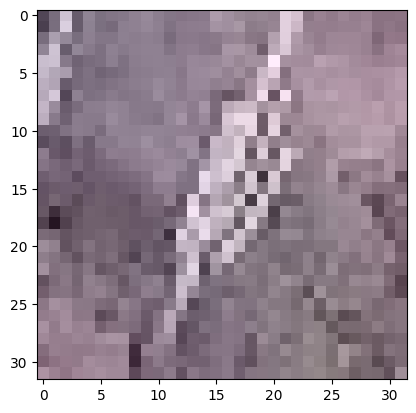

1
(32, 32, 3)
17500


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import zipfile
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from keras.callbacks import EarlyStopping


train_data = pd.read_csv('/kaggle/input/aerial-cactus-identification/train.csv')
print(train_data['has_cactus'].value_counts())
submission_df = pd.read_csv('/kaggle/input/aerial-cactus-identification/sample_submission.csv')

display(train_data.head())
zip_ref = zipfile.ZipFile('/kaggle/input/aerial-cactus-identification/train.zip')
zip_ref.extractall()
for i in range(10):
    
    img = mpimg.imread(f'train/{train_data.iloc[i].id}')
    plt.imshow(img)
    plt.show()
    print(train_data.iloc[i]['has_cactus'])
print(img.shape)
images = []
print(len(train_data))
for i in range(len(train_data)):
    img = mpimg.imread(f'train/{train_data.iloc[i].id}')
    images.append(img)
train_data['images'] = images
images = np.array(images)


Now we will split the data into train and test sets so that we have a set of data unseen by the model on which we can test it.

In [2]:
X_train,X_test,y_train, y_test = train_test_split(images,train_data['has_cactus'], stratify = train_data['has_cactus'], random_state = 28)



Below we have the code for the first model I build for this project. It was intentionally very simple, but still managed to achieve an ROC-AUC score of 0.95.

In [3]:
#model = Sequential()
#model.add(layers.Conv2D(20, input_shape = (32,32,3), activation = 'relu', kernel_size = 3))
#model.add(layers.Flatten())
#model.add(layers.Dense(1, activation = 'sigmoid'))
#model.compile(optimizer = 'Adam', loss = 'binary_crossentropy')
#model.fit(X_train, y_train, epochs = 5)
#y_pred_test = model.predict(X_test)
#print(roc_auc_score(y_test,y_pred_test))

Next I generated additional training instances by rotating the given images. The results of the model should be unaffected by rotations,so this should be a good way to artificially increase the size of the training set and improve the efficacy of my model. I also confirm that the rotations worked correctly by examing four of the rotated images.

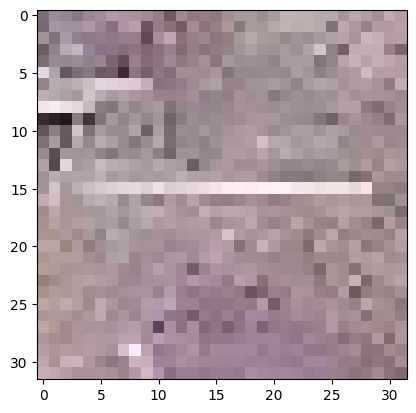

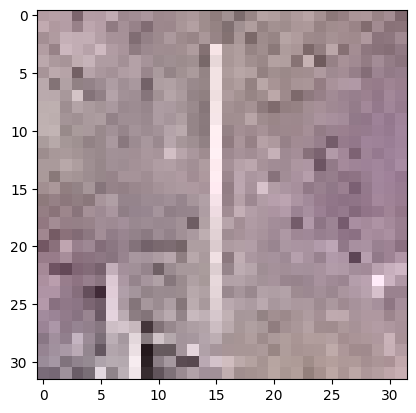

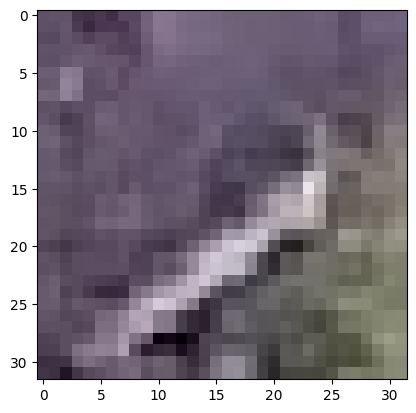

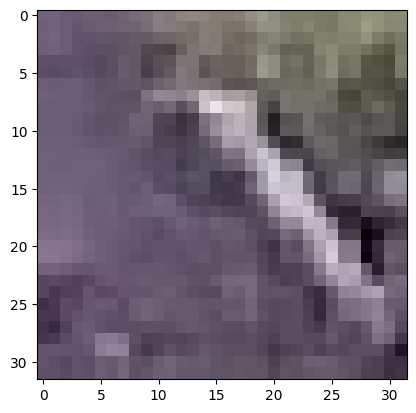

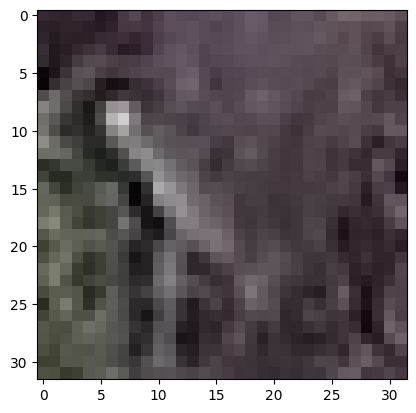

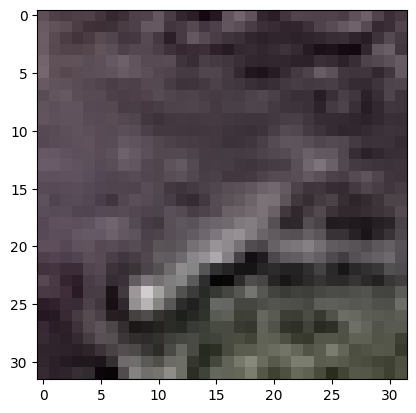

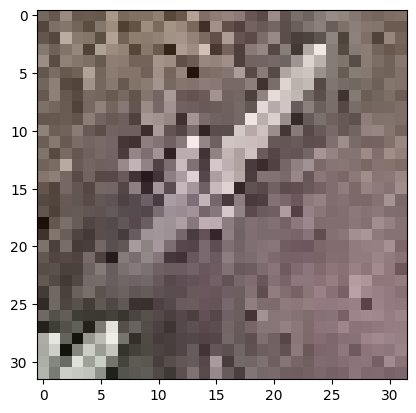

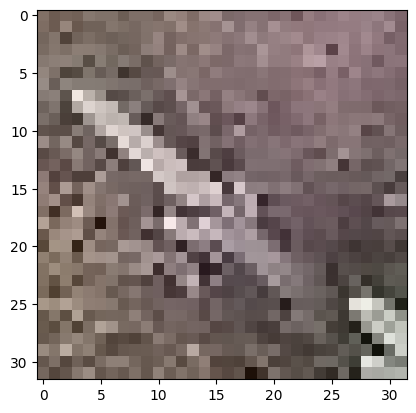

In [4]:
for i in range(4):
    plt.imshow(X_train[i])
    plt.show()
    rotation1 = np.rot90(X_train[i])
    plt.imshow(rotation1)
    plt.show()
transformed_images = []
transformed_labels = []
for i in range(len(X_train)):
    image = X_train[i]
    label = y_train.iloc[i]
    transformed_images.append(image)
    transformed_labels.append(label)
    image = np.rot90(image)
    transformed_images.append(image)
    transformed_labels.append(label)
    image = np.rot90(image)
    transformed_images.append(image)
    transformed_labels.append(label)
    image = np.rot90(image)
    transformed_images.append(image)
    transformed_labels.append(label)
transformed_images = np.array(transformed_images)
transformed_labels = np.array(transformed_labels)
    
    

In [5]:
zip_ref = zipfile.ZipFile('/kaggle/input/aerial-cactus-identification/test.zip')
zip_ref.extractall()

Now we will build a more complicated model using a longer training time and callbacks to improve performance.

In [6]:
model = Sequential()
model.add(layers.Conv2D(20, input_shape = (32,32,3), activation = 'relu', kernel_size = 3, padding = 'same'))
model.add(layers.Conv2D(15, activation = 'relu', kernel_size = 3, padding = 'same'))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation = 'sigmoid'))
callback = EarlyStopping(patience = 2, verbose = 1, restore_best_weights = True)
model.compile(optimizer = 'Adam', loss = 'binary_crossentropy')
model.fit(transformed_images, transformed_labels, epochs = 20, validation_split = 0.2, callbacks = [callback])
y_pred_test = model.predict(X_test)
print(roc_auc_score(y_test,y_pred_test))

Epoch 1/20
1313/1313 [==============================] - 38s 28ms/step - loss: 0.3067 - val_loss: 0.1343
Epoch 2/20
1313/1313 [==============================] - 38s 29ms/step - loss: 0.1170 - val_loss: 0.0901
Epoch 3/20
1313/1313 [==============================] - 35s 27ms/step - loss: 0.0594 - val_loss: 0.0632
Epoch 4/20
1313/1313 [==============================] - 36s 27ms/step - loss: 0.0430 - val_loss: 0.0921
Epoch 5/20
1313/1313 [==============================] - 35s 27ms/step - loss: 0.0373 - val_loss: 0.0682
Epoch 5: early stopping
137/137 [==============================] - 1s 9ms/step
0.9975430133156789


In [7]:
images = []
for i in range(len(submission_df)):
    img = mpimg.imread(f'test/{submission_df.iloc[i].id}')
    images.append(img)
images = np.array(images)
print(images.shape)
preds = model.predict(images)
submission_df['has_cactus'] = preds
submission_df['has_cactus'] = np.round(preds)
display(submission_df)
submission_df.to_csv('submission.csv', index = False)

(4000, 32, 32, 3)
125/125 [==============================] - 1s 8ms/step


,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,1.0
1,0017242f54ececa4512b4d7937d1e21e.jpg,1.0
2,001ee6d8564003107853118ab87df407.jpg,0.0
3,002e175c3c1e060769475f52182583d0.jpg,0.0
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.0
...,...,...
3995,ffaafd0c9f2f0e73172848463bc2e523.jpg,1.0
3996,ffae37344310a1549162493237d25d3f.jpg,1.0
3997,ffbd469c56873d064326204aac546e0d.jpg,1.0
3998,ffcb76b7d47f29ece11c751e5f763f52.jpg,1.0


This model performed much better! Before adding additional rotated images, it achieved an ROC-AUC score of .983. After adding the new images this score jumped to 0.996!